In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
import time

import duckdb 
conn = duckdb.connect('analysis.db') # create an in-memory database

In [2]:
conn.sql("SHOW ALL TABLES")

┌──────────┬─────────┬──────────────────────┬──────────────────────┬─────────────────────────────┬───────────┐
│ database │ schema  │         name         │     column_names     │        column_types         │ temporary │
│ varchar  │ varchar │       varchar        │      varchar[]       │          varchar[]          │  boolean  │
├──────────┼─────────┼──────────────────────┼──────────────────────┼─────────────────────────────┼───────────┤
│ analysis │ main    │ A10_1_1_MAP_20240320 │ [AD, AD_BC, RPTR_BC] │ [VARCHAR, VARCHAR, VARCHAR] │ false     │
│ analysis │ main    │ A10_1_2_MAP_20240320 │ [AD, AD_BC, RPTR_BC] │ [VARCHAR, VARCHAR, VARCHAR] │ false     │
│ analysis │ main    │ A10_1_ADBC           │ [index, AD BCs]      │ [VARCHAR, BIGINT]           │ false     │
│ analysis │ main    │ A10_1_AD_FIL         │ [index, AD BCs]      │ [VARCHAR, BIGINT]           │ false     │
│ analysis │ main    │ A10_1_RPTR           │ [index, RPTR BCs]    │ [VARCHAR, BIGINT]           │ false     │
│

In [3]:
A10map1 = pd.read_csv('A10_1_tbcRAW_v2.csv')
A10map1.head(20)

,Unnamed: 0,AD,AD_BC,RPTR_BC,Designed
0,0,ACTTCTAACTTTCATCATGATCAAGAAGCTGACTTTGTCTTGTTTC...,CCCCGCCATGG,CAGTTATCTCGTTA,0
1,1,AAAGCTACTGGTCCACCAGCATCTCCAGTTATTAGAGGTTCTGCTT...,TGCATTCCTAC,ACGGATTAGTCGTA,0
2,2,GGTTCTGGTACTCCACAAAGGAAAGGTTCTGTTGCTTCTACTGGTC...,TTTCAGCTGTT,GAAGGAGCAGGTGC,0
3,3,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,TTCGCTTAATG,AGAAGAACTGAGGA,1
4,4,TCTTGGTTGCCTTCTTCTTCTTCTTCTCCACCAGCTGCATCTGCTC...,CGTTGCTGACA,GAAGGAAATATGAT,0
5,5,ATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTTCTCCAT...,CCAGGTGATCA,AGACTATAGAAGTG,1
6,6,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TATGAATGTTA,TAATCGGATACGTA,1
7,7,AATCAACAAGCTCCAGATGCTCAACCACATCCATCTTCTCCAGCTC...,TAAGCTCGAGA,ACCTCCTCGCTCGC,0
8,8,NaN,NaN,NaN,0
9,9,CCATCTTCTGATATGTTGTTTGATTTGGTGACTTTCCAGCTTCTCC...,GATCACGTGGA,TAAAAAAAAGAGGG,0


In [4]:
A10map2 = A10map1.copy()
A10map2 = A10map2[A10map2['Designed']==1]

print('Unfiltered # Reads:', A10map1.shape[0])
print('Filtered # Reads:', A10map2.shape[0])

Unfiltered # Reads: 129306992
Filtered # Reads: 45830577


In [5]:
A10map2 = A10map2.drop(columns='Unnamed: 0')

In [8]:
A10map1rptrbcs = A10map1['RPTR_BC'].value_counts().to_frame().reset_index()
A10map1rptrbcs

,index,RPTR_BC
0,TGCAGGAGCCACTC,23553
1,GGCCCCTTAAGCTC,20000
2,GGGGTTAAGTTGAA,18676
3,GCAACTAACCATTT,14342
4,GCTAAAGGTGGCAT,12825
...,...,...
1607718,TAATGGCAAATAAC,1
1607719,GTAACTTGTCTATA,1
1607720,TACGACTCTATCAG,1
1607721,AACTACTGGGTGCC,1


In [12]:
conn.sql(""" CREATE TABLE A10_2_RPTR AS SELECT * FROM A10map1rptrbcs""")

<Axes: xlabel='RPTR_BC', ylabel='Count'>

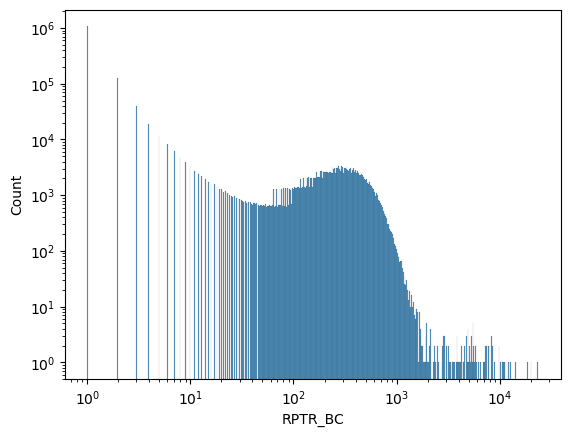

In [5]:
sns.histplot(data=A10map1rptrbcs[A10map1rptrbcs['index']!= 'X'], x='RPTR_BC', log_scale=(True, True))
# plt.xlim(50,1000)
# plt.ylim()

In [5]:
A10map2rptrbcs = A10map2['RPTR_BC'].value_counts().to_frame().reset_index()
A10map2rptrbcs

,index,RPTR_BC
0,TGCAGGAGCCACTC,20472
1,GGGGTTAAGTTGAA,16119
2,GCAACTAACCATTT,12799
3,GGCCCCTTAAGCTC,11827
4,GCTAAAGGTGGCAT,11424
...,...,...
588766,TGGCCTTCATGAAC,1
588767,TCATATGTCTATCG,1
588768,CGAAATTGTTGTCA,1
588769,ATCATAGTAAAACG,1


In [10]:
conn.sql(""" CREATE TABLE A10_2_RPTR_FIL AS SELECT * FROM A10map2rptrbcs""")

<Axes: xlabel='RPTR_BC', ylabel='Count'>

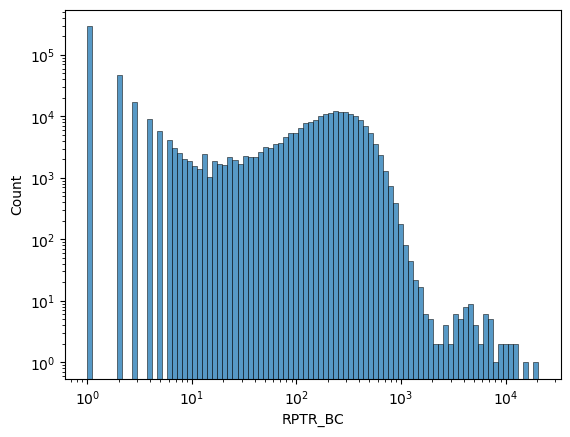

In [6]:
sns.histplot(data=A10map2rptrbcs, x='RPTR_BC', log_scale=(True, True))
# plt.xlim(50,1000)
# plt.ylim()

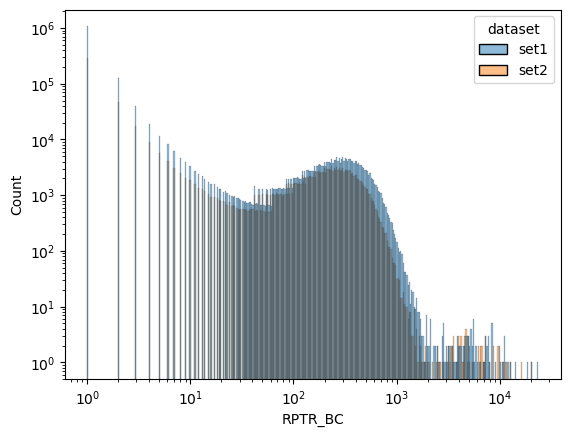

In [11]:
all_rbc = pd.concat([A10map1rptrbcs.assign(dataset='set1'), A10map2rptrbcs.assign(dataset='set2')])

sns.histplot(x='RPTR_BC', data=all_rbc, log_scale=(True, True),
                hue='dataset')
plt.savefig('A10_2_rptrbc_filtering.jpg')
plt.show()

In [12]:
A10map1adbcs = A10map1['AD_BC'].value_counts().to_frame().reset_index()
A10map1adbcs

,index,AD_BC
0,TTAAGCTCGAG,61332
1,CCTTAAGCTCG,59104
2,CTTAAGCTCGA,57190
3,CCCTTAAGCTC,49709
4,CCCCTTAAGCT,38439
...,...,...
1605878,GCCCTCCCCAG,1
1605879,GGGGTGGTCCT,1
1605880,CAGTATATTTT,1
1605881,CCGCTCCGATC,1


In [13]:
conn.sql(""" CREATE TABLE A10_2_ADBC AS SELECT * FROM A10map1adbcs""")

<Axes: xlabel='AD_BC', ylabel='Count'>

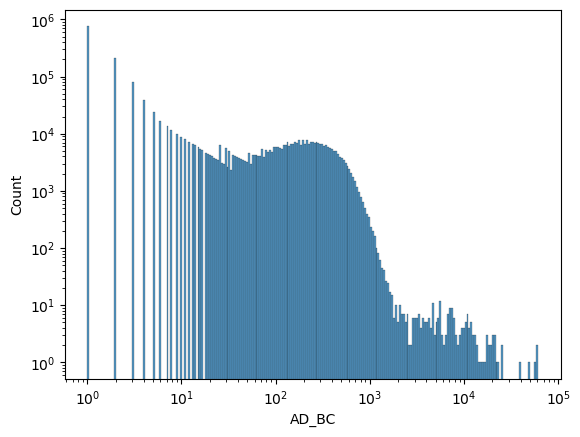

In [7]:
sns.histplot(data=A10map1adbcs[A10map1adbcs['index']!= 'X'], x='AD_BC', log_scale=(True, True))

In [14]:
A10map2adbcs = A10map2['AD_BC'].value_counts().to_frame().reset_index()
A10map2adbcs

,index,AD_BC
0,GCTAAGGCGTA,20348
1,AAGAGCCGGTA,16055
2,TGTACCTACAT,12766
3,AGTAGTTAATA,11358
4,ATTGATAGGAC,10706
...,...,...
649230,CCAGGCTAGTT,1
649231,TTAGGGTGTTC,1
649232,TTACAGGGTCA,1
649233,TTCTCGATAAT,1


In [16]:
conn.sql(""" CREATE TABLE A10_2_AD_FIL AS SELECT * FROM A10map2adbcs""")

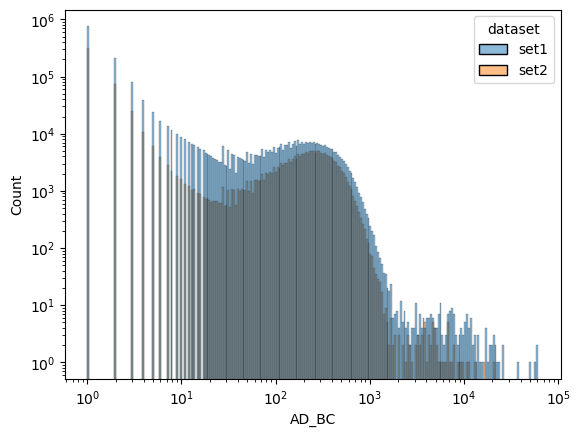

In [15]:
all_abc = pd.concat([A10map1adbcs.assign(dataset='set1'), A10map2adbcs.assign(dataset='set2')])

sns.histplot(x='AD_BC', data=all_abc, log_scale=(True, True),
                hue='dataset')
plt.savefig('A10_2_adbc_filtering.jpg')
plt.show()

In [17]:
A10map1tiles = A10map1['AD'].value_counts().to_frame().reset_index()
A10map1tiles

,index,AD
0,CAACAAACTCAACCATTGCCAGAATTGGTTCAACCAGTTCAACCAA...,23510
1,TCTGCTGATTATTCTGGTTTGCAATCTGATTATTCTCCATTGACTG...,19397
2,TTGGCTTCTGATTCTTTGCCACCATTGCCACCAACTCCAAGATCTC...,18023
3,AATAATTTGCCATCTGATTGGTTGTGTTCTGGTAATGGTGGTAATA...,17688
4,GATCAAGCTTTGTCTGGTGATCCATGGTATCCATTGTTTCCACAAG...,14882
...,...,...
7759022,TCTAAACACAGGTTCTCTATGTTTCCAGATCAATCTCTGCTCCAGA...,1
7759023,TCTCAGCTCCATCTATGTCTCCAGCTCCATCTAGACAAGGTGTTAA...,1
7759024,GCTAATATTTCTTCTCAAGAATTTCCATTGTTTACTACTCATTCTC...,1
7759025,GATAAAGACTTTGTTGATTTGGGTAGATATGATAGGAAGAGAGCAT...,1


In [14]:
conn.sql(""" CREATE TABLE A10_2_TILE AS SELECT * FROM A10map1tiles""")

<Axes: xlabel='AD', ylabel='Count'>

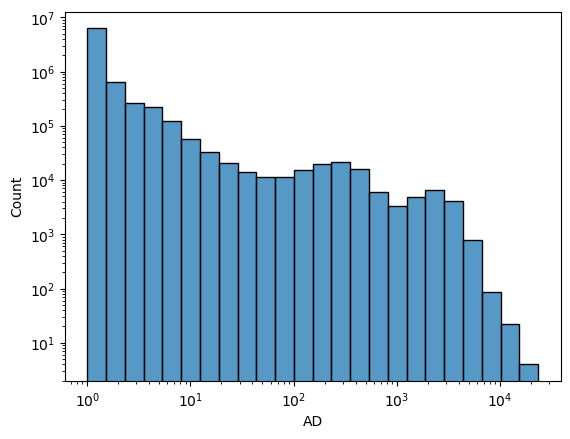

In [9]:
sns.histplot(data=A10map1tiles[A10map1tiles['index']!= 'X'], x='AD', log_scale=(True, True))

In [18]:
A10map2tiles = A10map2['AD'].value_counts().to_frame().reset_index()
A10map2tiles

,index,AD
0,CAACAAACTCAACCATTGCCAGAATTGGTTCAACCAGTTCAACCAA...,23510
1,TCTGCTGATTATTCTGGTTTGCAATCTGATTATTCTCCATTGACTG...,19397
2,TTGGCTTCTGATTCTTTGCCACCATTGCCACCAACTCCAAGATCTC...,18023
3,AATAATTTGCCATCTGATTGGTTGTGTTCTGGTAATGGTGGTAATA...,17688
4,GATCAAGCTTTGTCTGGTGATCCATGGTATCCATTGTTTCCACAAG...,14882
...,...,...
20630,ATTAATGAAGTTCCATCTAATAATTCTAATAATAATAATAATAATA...,5
20631,AAAGGTTCTACTACTGGTGCTGGTGTTAGGAAGAGAACTGCTCCAT...,3
20632,ATGAAGAGAGCTAGAAATACTTTGGCTGCTAGGAAATCTAGAGAAA...,3
20633,AATAATAATAATAATAATAATACTTCTAATAATGGATTCTCTGCTA...,2


In [19]:
conn.sql(""" CREATE TABLE A10_2_TILE_FIL AS SELECT * FROM A10map2tiles""")

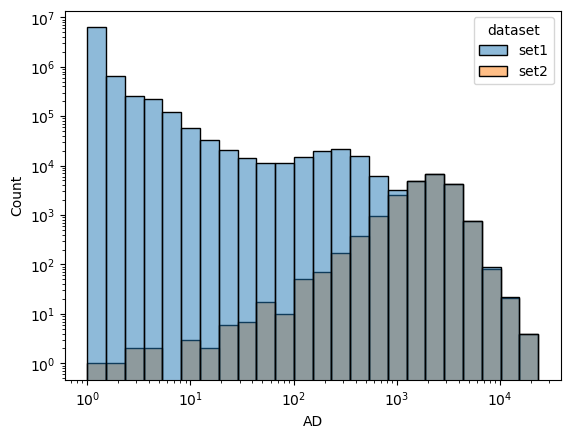

In [36]:
all_tile = pd.concat([A10map1tiles.assign(dataset='set1'), A10map2tiles.assign(dataset='set2')])

sns.histplot(x='AD', data=all_tile, log_scale=(True, True),
                hue='dataset')
plt.savefig('A10_2_tile_filtering.jpg')
plt.show()

In [6]:
A10map2

,AD,AD_BC,RPTR_BC,Designed
3,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,TTCGCTTAATG,AGAAGAACTGAGGA,1
5,ATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTTCTCCAT...,CCAGGTGATCA,AGACTATAGAAGTG,1
6,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TATGAATGTTA,TAATCGGATACGTA,1
10,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,GGTCGAAGTTC,AATTGACCCGTCAG,1
13,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,CGGCCCTTTCC,ATGGCGCCCTCGAA,1
...,...,...,...,...
129306935,AACTTTGGTGATTTGGATGCTACTTCTACTGAGAATTGGTTTCCAT...,GTATTAATGAA,ATAGTCAATACATT,1
129306945,GTTTCTGCTTCTGTTTCTCCAGCTTCTTCTTCTGTTGGTCCAGAAT...,GACTATGAATA,AGAACCTAGTTTGG,1
129306961,TTCTTGAGATTGCCACCAGAAATTAGAAATATGATTTATAAATATG...,TACATGCGCCG,CCGCACTCTGGTAA,1
129306965,AGAGTTCATCAAATTATTCAAGCTACTGGTCATCCATCTTCTCCAT...,AAGAGTAGTGG,TAGTCTCAAATTAA,1


In [9]:
A10map2_TBB = A10map2.copy()
adcol = A10map2_TBB['AD_BC'].copy()
rpcol = A10map2_TBB['RPTR_BC'].copy()

A10map2_TBB['Cat'] = A10map2_TBB['AD'].str.cat(adcol, sep="-").str.cat(rpcol, sep="-")
# A10map2_TBB['BC Pairs'] = A10map2_TBB['AD BCs'].str.cat(rpcol, sep='-')

A10map2_TBB.head()

,AD,AD_BC,RPTR_BC,Designed,Cat
3,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,TTCGCTTAATG,AGAAGAACTGAGGA,1,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...
5,ATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTTCTCCAT...,CCAGGTGATCA,AGACTATAGAAGTG,1,ATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTTCTCCAT...
6,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TATGAATGTTA,TAATCGGATACGTA,1,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...
10,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,GGTCGAAGTTC,AATTGACCCGTCAG,1,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...
13,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,CGGCCCTTTCC,ATGGCGCCCTCGAA,1,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...


In [10]:
map2_TBBcounts = A10map2_TBB['Cat'].value_counts().to_frame().reset_index()
map2_TBBcounts

,index,Cat
0,CAACAAACTCAACCATTGCCAGAATTGGTTCAACCAGTTCAACCAA...,20241
1,AATAATTTGCCATCTGATTGGTTGTGTTCTGGTAATGGTGGTAATA...,15933
2,GATCAAGCTTTGTCTGGTGATCCATGGTATCCATTGTTTCCACAAG...,12670
3,CCAGACTTTGATGCTTTGTTTGATTTGACTGCTAATTCATTTGTTG...,11259
4,GCTGTTGTTACTACTTCTGCTGCTTCTCAAGGTGCTGGTGGTAATT...,10592
...,...,...
1177744,GGTTCTGCTCCACCATCTACTGCATTTACTAATATTACTTCTCCAG...,1
1177745,GACTTTGATTCTGGTGGTCCAAATACTTGGTTCTCTTTGTTTCCAG...,1
1177746,GGTGCTTCTTTGATGCCAGCATTTCAAGCTGGTGGATTCTCTTTGG...,1
1177747,ACTTATACTAATTTGACTACTCCAGGTACTTCTTATATTGATTCTC...,1


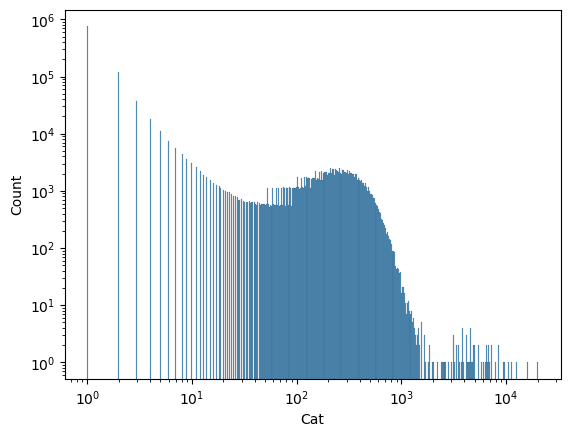

In [11]:
sns.histplot(data=map2_TBBcounts, x='Cat', log_scale=(True, True))
plt.savefig('A10_2_TBB_fil_counts.jpg')
plt.show()

In [12]:
conn.sql(""" CREATE TABLE A10_2_TBB_FIL AS SELECT * FROM map2_TBBcounts""")

In [28]:
A10map3 = A10map2.drop_duplicates().reset_index().drop(columns=['Designed', 'index'])

A10map3

,AD,AD_BC,RPTR_BC,Designed
3,AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTT...,TTCGCTTAATG,AGAAGAACTGAGGA,1
5,ATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTTCTCCAT...,CCAGGTGATCA,AGACTATAGAAGTG,1
6,TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACT...,TATGAATGTTA,TAATCGGATACGTA,1
10,CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCAC...,GGTCGAAGTTC,AATTGACCCGTCAG,1
13,GGTTTGGATAAGATTGAAGTTCCAGAATTGTCTCCATCTATTGGTA...,CGGCCCTTTCC,ATGGCGCCCTCGAA,1
...,...,...,...,...
129305924,TCTACTCAACCATTGTTCTCTGCTTTGCCACCACAAGTTGATTTGA...,TCATACTCGTT,ATACGTGGCGTTTA,1
129305973,GGTCATCAAACTACTTCTTCTGCATTTACTAATAGATTCTCTTCTT...,CCTTCGACTAT,CTGGGCTGGCATCA,1
129306326,AAAGCTGATGTTACTCCATCTTCTCCAATGATTAGAACTACTTCTT...,ACAGATCGTAC,TGCTAACATTCGGT,1
129306496,CAACAACCAGCTCAAGCTGATAAAGGTAAAGAAATTTGGGATGATG...,ATATTAACGAC,CCAAATAGTCTAAT,1


In [33]:
conn.sql(""" CREATE TABLE A10_2_MAP_20240320 AS SELECT * FROM A10map3""")

In [13]:
conn.close()

In [35]:
A10map3.to_parquet('A10_2_MAP_20240320.parquet')

In [23]:
datax = {'col1': [1, 2, 3, 2, 4, 3],
        'col2': ['A', 'B', 'C', 'B', 'D', 'C']}
dfx = pd.DataFrame(datax)
dfx

,col1,col2
0,1,A
1,2,B
2,3,C
3,2,B
4,4,D
5,3,C


In [24]:
# Drop all duplicate rows
dfx.drop_duplicates(inplace=True)
# Print the resulting DataFrame
dfx

,col1,col2
0,1,A
1,2,B
2,3,C
4,4,D
